<a href="https://www.kaggle.com/code/oscarjcc2002/optimizacion-portafolios-sr-qp-smc-ga?scriptVersionId=275653668" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/barra-progreso/Barra De Progreso/barra_progreso.py


# Setup

In [2]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 7.8 MB/s eta 0:00:00


In [3]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   4
  On-line CPU(s) list:    0-3
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   2
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4400.45
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Optimización de Portafolios: Maximización del Ratio de Sharpe mediante Programación Cuadrática, Simulación Monte Carlo y Algoritmos Genéticos

### Resumen
Este trabajo presenta un estudio comparativo entre la optimización de portafolios mediante programación cuadrática clásica y algoritmos genáticos. El objetivo es maximizar el rendimiento ajustado al riesgo bajo restricciones de inversión realistas. Se emplea la teoría moderna de portafolios de Markowitz (1952) y se desarrolla un componente evolutivo implementado en Python para resolver el problema de maximización del ratio de Sharpe. Los resultados muestran que el enfoque evolutivo logra soluciones factibles y competitivas, aunque sin mejoras significativas respecto al método determinista.

* **Palabras Clave**: Optimización de portafolios, programación cuadrática, Monte Carlo, algoritmos genéticos, ratio de Sharpe.

## Introducción
La optimización de portafolios es una áreas estudiada dentro de las finanzas cuantitativas y la ingeniería financiera, ya que permite identificar combinaciones óptimas de activos para maximizar el retorno esperado bajo un nivel de riesgo determinado. El modelo pionero de Markowitz (1952)~\cite{markowitz1952portfolio} estableció la base de la Teoría Moderna de Portafolios (MPT), definiendo el riesgo mediante la varianza y proponiendo la frontera eficiente como conjunto de combinaciones óptimas.

Sin embargo, los modelos clásicos de optimización lineal presentan limitaciones cuando se incorporan restricciones realistas como límites de inversión, costos de transacción. En este contexto, las técnicas como la programación cuadrática, simulación de Monte Carlo o los algoritmos genéticos ofrecen una alternativa flexible para abordar problemas no lineales o no convexos.

El reto de optimizar un portafolio esta en la gestión de diversos activos y consideraciones de riesgo para crear una proporción de asignación de capital a cada activo destinada a aumentar la rentabilidad o reducir la exposición al riesgo~\cite{de2025analisis}.

En este trabajo se desarrolla un modelo de optimización de portafolio con restricciones exactas mediante programación cuadrática, simulación de Monte Carlo y algoritmos genéticos, combinando la teoría de Markowitz con la implementación práctica en Python. Además, se utiliza la tasa de rentabilidad del bono de Estados Unidos a 10 años como tasa libre de riesgo, siguiendo la recomendación de Damodaran (2008)~\cite{damodaran2008riskfree}.

## Metodologia

El modelo de Markowitz busca minimizar la varianza del portafolio dado un retorno esperado:

\begin{equation}
\min_{w} w^T \Sigma w
\end{equation}
sujeto a:
\begin{equation}
\sum_{i=1}^{n} w_i = 1, \quad w_i \ge 0
\end{equation}

donde $w$ es el vector de pesos de los activos y $\Sigma$ la matriz de covarianzas.  
El rendimiento esperado del portafolio se define como:

\begin{equation}
E[R_p] = w^T \mu
\end{equation}

donde $\mu$ representa el vector de rendimientos esperados de cada activo.


Consideremos un universo compuesto por $n$ activos, cada uno con una rentabilidad esperada $\mu_i$, donde $i = 1, 2, \dots, n$. Podemos definir el vector de rentabilidades esperadas como

\begin{equation}
    \mu = \left[ \mu_1, \mu_2, \dots, \mu_n \right]^T .
\end{equation}

A partir de estas rentabilidades se construye la matriz de covarianzas $\Sigma$, cuyos elementos $\sigma_{ij}$ representan la covarianza entre los activos $i$ y $j$:

\begin{equation}
    \Sigma =
    \begin{bmatrix}
    \sigma_{11} & \sigma_{12} & \dots & \sigma_{1n} \\
    \sigma_{21} & \sigma_{22} & \dots & \sigma_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    \sigma_{n1} & \sigma_{n2} & \dots & \sigma_{nn}
    \end{bmatrix},
\end{equation}

la cual es una matriz simétrica y semidefinida positiva.

Sea ahora $\omega$ el vector que contiene las proporciones de el capital invertido en cada activo:
\begin{equation}
    \omega = \left[ \omega_1, \omega_2, \dots, \omega_n \right]^T .
\end{equation}

Con estos parámetros, las principales características del portafolio son:

* Rentabilidad esperada del portafolio:
\begin{equation}
    \mu_p = \mu_1\omega_1 + \mu_2\omega_2 + \cdots + \mu_n\omega_n = \mu^T\omega    
\end{equation}
* Varianza del portafolio
\begin{equation}
    \sigma_p^2 = \omega^T \Sigma \omega
\end{equation}

Finalmente, la restricción de presupuesto impone que la totalidad del capital sea invertido, lo cual se expresa como

\begin{equation}
    \omega_1 + \omega_2 + \cdots + \omega_n = 1
\end{equation}

y podemos compactar con un vector $l = \left[1,1,\dots,1\right]^T$ y la vemos como

\begin{equation}
    l^T\omega = 1
\end{equation}

Considerando que nuestro objetivo al optimizar un portafolio es minimizar la varianza del portafolio, con una rentabilidad esperada del portafolio lo cual podemos formular el siguiente problema de programación cuadrática:

\begin{align}
    \min \quad & \frac{1}{2}\omega^T\Sigma \omega \\
    \text{s.a.} \quad & \mu^T\omega = \mu_p \\
    & l^T\omega = 1 \\
    & \omega \geq 0
\end{align}

donde agregamos la restricción $\omega \geq 0$ con la consideración de que no tenemos ventas a corto plazo. Al resolver este problema para distintos valores de la rentabilidad objetivo $\mu_p$, se obtiene un conjunto de soluciones que representan los portafolios de mínima varianza para cada nivel de retorno esperado.  
La colección de todos estos portafolios conforma la frontera eficiente, la cual describe la combinación óptima de riesgo y rendimiento, y constituye una de las principales herramientas del modelo de Markowitz~\cite{markowitz1952portfolio} para la selección racional de portafolios.

El desempeño ajustado por riesgo se mide a través del \textbf{ratio de Sharpe}:

\begin{equation}
S = \frac{E[R_p] - R_f}{\sqrt{w^T \Sigma w}}
\end{equation}

donde $R_f$ es la tasa libre de riesgo. Según \cite{damodaran2008riskfree}, esta tasa debe corresponder a bonos del gobierno a largo plazo, en este caso, el bono estadounidense a 10 años obtenido de \cite{us10ybond}.

Un ratio $S < 1$ indica un desempeño bajo, $1 < S < 2$ aceptable, $2 < S < 3$ muy bueno, y superior a 3 excelente.

Con el ratio de Sharpe el problema de optimización~\cite{kourtis2016sharpe} que se encuentra es:

\begin{align}
    \max \quad & \frac{\mu^T\omega - R_f}{\sqrt{\omega^T\Sigma \omega}} \\
    \text{s.a.} \quad & l^T\omega = 1 \\
    & \omega \geq 0
\end{align}

el cual tiene un función objetivo , lo que nos genera un problema de optimización no lineal, pero podemos reformular como un problema de programación cuadrática

En este caso, la función objetivo es una razón entre un término lineal y la raíz cuadrada de un término cuadrático.  
Esta forma no es convexa y no está definida cuando $\omega^\top \Sigma \omega = 0$, lo que convierte el problema en una optimización no lineal.  
Sin embargo, el problema puede reformularse como uno de programación cuadrática equivalente, al fijar un rendimiento objetivo $\mu_p^*$ y minimizar la varianza sujeta a dicho retorno:

\begin{align}
    \min \quad & \frac{1}{2}\omega^T\Sigma \omega \\
    \text{s.a.} \quad & \mu^T\omega - R_f = \mu_p^* \\
    & l^T\omega = 1 \\
    & \omega \geq 0
\end{align}

Al resolver este problema para distintos valores de $\mu_p^*$ se obtiene la frontera eficiente, el portafolio con mayor ratio de Sharpe se identifica como aquel que presenta la pendiente máxima en dicha frontera.

### Método de Programación Cuadrática

Consideremos el caso clásico de optimización de portafolios sin la restricción de ventas a corto plazo. El problema puede formularse como:

\begin{align}
    \min \quad & \frac{1}{2}\omega^T\Sigma \omega \\
    \text{s.a.} \quad & \mu^T\omega = \mu_p \\
    & l^T\omega = 1 \\
\end{align}

donde el objetivo es determinar la proporción óptima de capital a asignar en cada activo, de manera que se minimice la varianza total del portafolio para un nivel esperado de retorno $\mu_p$.  

Este problema puede resolverse de forma analítica mediante el método de los multiplicadores de Lagrange, dado que únicamente involucra restricciones de igualdad (véase el Apéndice~\ref{apend:lagrange}). A partir de dicha solución se obtiene la relación funcional entre el rendimiento esperado $\mu_p$ y la volatilidad $\sigma_p$, que define la conocida frontera eficiente en teoría moderna de portafolios.

En este trabajo, sin embargo, se incluye la restricción de no ventas a corto plazo y la optimización del ratio de Sharpe, lo que conduce al siguiente problema de programación cuadrática con restricciones de desigualdad:

\begin{align}
    \min \quad & \frac{1}{2}\omega^T\Sigma \omega \\
    \text{s.a.} \quad & \mu^T\omega - R_f = \mu_p^* \\
    & l^T\omega = 1 \\
    & \omega \geq 0
\end{align}

La inclusión de la restricción de no negatividad incrementa la complejidad de resolución del problema, por lo que se requiere el uso de algoritmos numéricos y computacionales más eficientes para aproximar la solución óptima~\cite{best2017quadratic,Peressini1988}.  

Para resolver este problema se empleó la biblioteca de Python PyPortfolioOpt\cite{Martin2021}, que permite resolver numéricamente problemas de optimización cuadrática para la optimización de portafolios, obtener los portafolios de máxima ratio de Sharpe y construir la correspondiente frontera eficiente (véase la Figura~\ref{fig:frontera_eficiente}).

### Método de Simulación de Monte Carlo

La simulación de Monte Carlo es un método o tipo de algoritmo computacional que buscar aprovechar el computo para realizar un muestreo aleatorio repetitiva de una posible situaciones incierta y evaluar o prever posibles resultados~\cite{noauthor_2024-zm}.

El método de Monte Carlo construye un modelo que permite generar posibles resultados para aquellas variables que presentan incertidumbre. Posteriormente, el modelo repite este proceso múltiples veces utilizando conjuntos de números aleatorios sujetos a determinadas restricciones. Al realizar miles de estas simulaciones, se obtiene una amplia distribución de resultados posibles, a partir de la cual es posible identificar, mediante métricas de desempeño, las soluciones más convenientes para el problema analizado~\cite{illana2013metodos,serrano2011optimizacion}.

En la optimización del portafolio, el método de Monte Carlo ofrece diversas ventajas, ya que permite explorar una amplia gama de combinaciones posibles de asignación de capital entre los activos.  
Este enfoque se basa en la generación aleatoria de pesos que satisfacen las restricciones del modelo, y la evaluación sistemática de su desempeño según el criterio del ratio de Sharpe~\cite{de2025analisis}.



### Método de Algoritmo Genético

La computación evolutiva constituye un conjunto de técnicas inspiradas en la selección natural, con el objetivo de encontrar soluciones óptimas en espacios de búsqueda complejos. Los algoritmos genéticos (AG), introducidos por \cite{holland1975adaptation}, son una de las metodologías más empleadas dentro de esta familia.

En la optimización de portafolios, los AG permiten manejar restricciones de tipo no lineal o discreto, el flujo básico del algoritmo incluye:

* Generar una población inicial de soluciones factibles (vectores de pesos).
* Evaluar la función objetivo (minimizar la varianza o maximizar el ratio de Sharpe).
* Seleccionar los mejores individuos.
* Aplicar operadores genéticos: cruce, mutación y elitismo.
* Iterar hasta alcanzar la convergencia.

Empleando la biblioteca de Python \texttt{DEAP}, que facilita la implementación de algoritmos evolutivos de manera eficiente y modular, extendido mediante la integración de un componente evolutivo y restricciones exactas:

* $w_i \ge 0$ para todos los activos.
* $\sum w_i = 1$ (preservar el capital total).
* $0.05 \le w_i \le 0.4$ para cada activo.

El algoritmo genético fue configurado con una población inicial de 300 individuos, probabilidad de cruce del 0.7 y mutación del 0.2, en un total de 200 generaciones. La función de aptitud se definió como la maximización del ratio de Sharpe.


## Experimentación

### Herramientas Utilizadas

El código por completo fue hecho en Python, ya que tiene distintas librerías que permiten la facilidad de extraer, organizar, manipular y analizar los datos, las librerías usadas son:

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
#from datetime import datetime, timedelta
import time
from pypfopt.efficient_frontier import EfficientFrontier
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("/kaggle/input/barra-progreso/Barra De Progreso")
from barra_progreso import bP

Descarga: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.00% 00:00:00:009



### Extracción y análisis de datos

En este estudio se analiza un portafolio compuesto por las siguientes empresas:

* Apple Inc. (AAPL)
* Microsoft Corp. (MSFT)
* Alphabet Inc. (GOOG)
* Amazon.com Inc. (AMZN)
* Tesla Inc. (TSLA)

Los datos históricos de precios fueron obtenidos mediante el paquete \texttt{yfinance}\cite{yfinance}, que permite descargar información financiera directamente desde el portal de \url{https://finance.yahoo.com}.
Se utilizaron los precios de cierre diario de cada activo desde inicios de 2019 hasta comienzos de 2025 (véase la Figura~\ref{fig:precios}).

In [6]:
def obtener_precios_historicos(simbolos, fecha_inicial, fecha_final, pausa = 0.0):#pausa=0.5):
    precios = pd.DataFrame()
    fallidos = []

    inicio = time.time()
    lim = len(simbolos)

    for sim in simbolos:
        print(bP(simbolos.index(sim), lim, inicio, f"⬇️Descargando:"), end = "\r")
        if simbolos.index(sim) == len(simbolos)-1:
          lim = simbolos.index(sim)
          print(bP(simbolos.index(sim), lim, inicio, f"✅ Descarga completada:"), end = "\n\n")
        
        try:
            # auto_adjust=True hace que 'Close' ya sea el precio ajustado
            df_temp = yf.download(sim, start=fecha_inicial, end=fecha_final,
                                      progress=False, auto_adjust=True)

            if df_temp.empty:
                fallidos.append(sim)
                continue

            precios[sim] = df_temp['Close']
            time.sleep(pausa)

        except Exception as e:
            fallidos.append(sim)

    return precios, fallidos

# === Ejemplo de uso ===
l_simbolos_activos = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']
fecha_inicial = '2019-01-01'
fecha_final = '2025-01-01'

precios_activos,fallidos = obtener_precios_historicos(l_simbolos_activos, fecha_inicial, fecha_final)

✅ Descarga completada: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.00% 00:00:01:484



In [7]:
#l_simbolos_activos = list(set(lista_simbolos_activos) - set(fallidos))
precios_activos

,AAPL,MSFT,GOOG,AMZN,TSLA
Date,,,,,
2019-01-02,37.575211,94.789673,51.937080,76.956497,20.674667
2019-01-03,33.832447,91.302551,50.457706,75.014000,20.024000
2019-01-04,35.276722,95.548973,53.171635,78.769501,21.179333
2019-01-07,35.198208,95.670822,53.056419,81.475502,22.330667
2019-01-08,35.869194,96.364517,53.448235,82.829002,22.356667
...,...,...,...,...,...
2024-12-24,257.286682,436.929108,196.932236,229.050003,462.279999
2024-12-26,258.103729,435.715790,196.463745,227.050003,454.130005
2024-12-27,254.685883,428.177216,193.413620,223.750000,431.660004


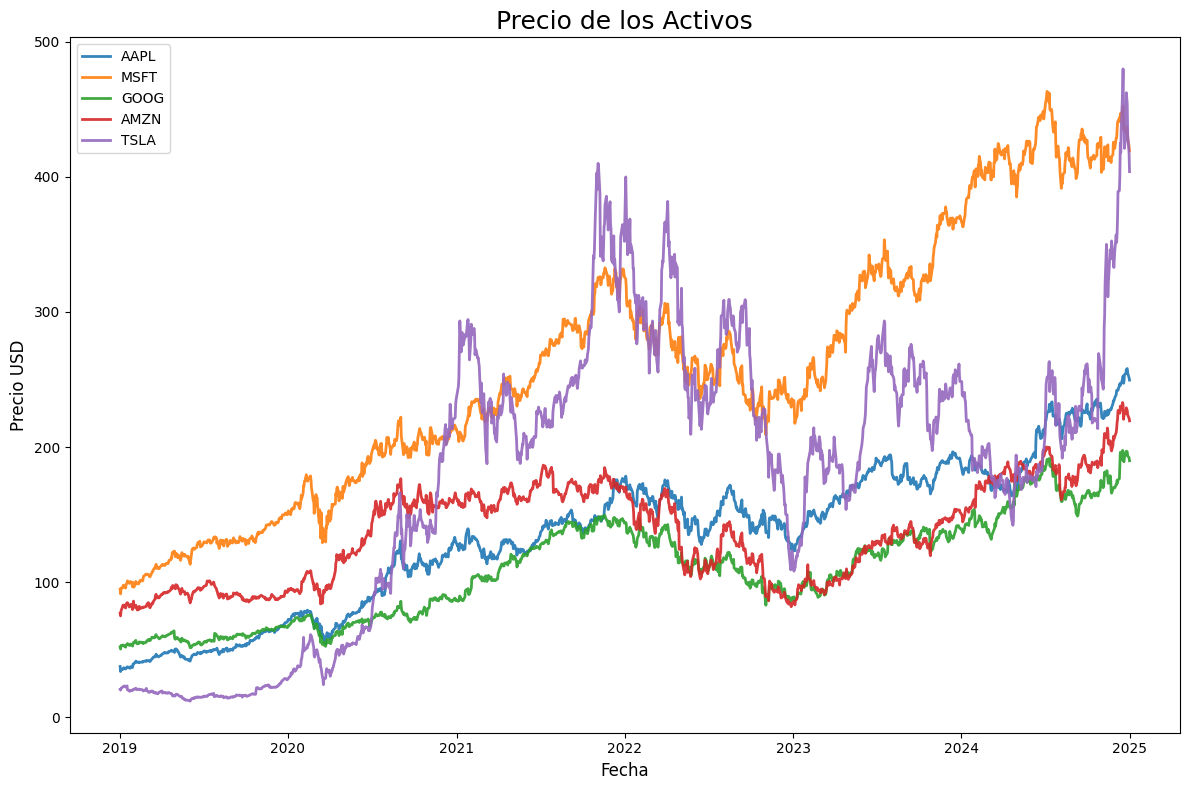

In [8]:
#plt.style.use("dark_background")
plt.figure(figsize=(12,8))
plt.plot(precios_activos,label = l_simbolos_activos,alpha=0.9, linewidth=2) 
plt.xlabel('Fecha',fontsize=12)
plt.ylabel('Precio USD',fontsize=12)
plt.title('Precio de los Activos',fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(f"/kaggle/working/Grafica_Precios_Activos.png",bbox_inches="tight")
plt.show()

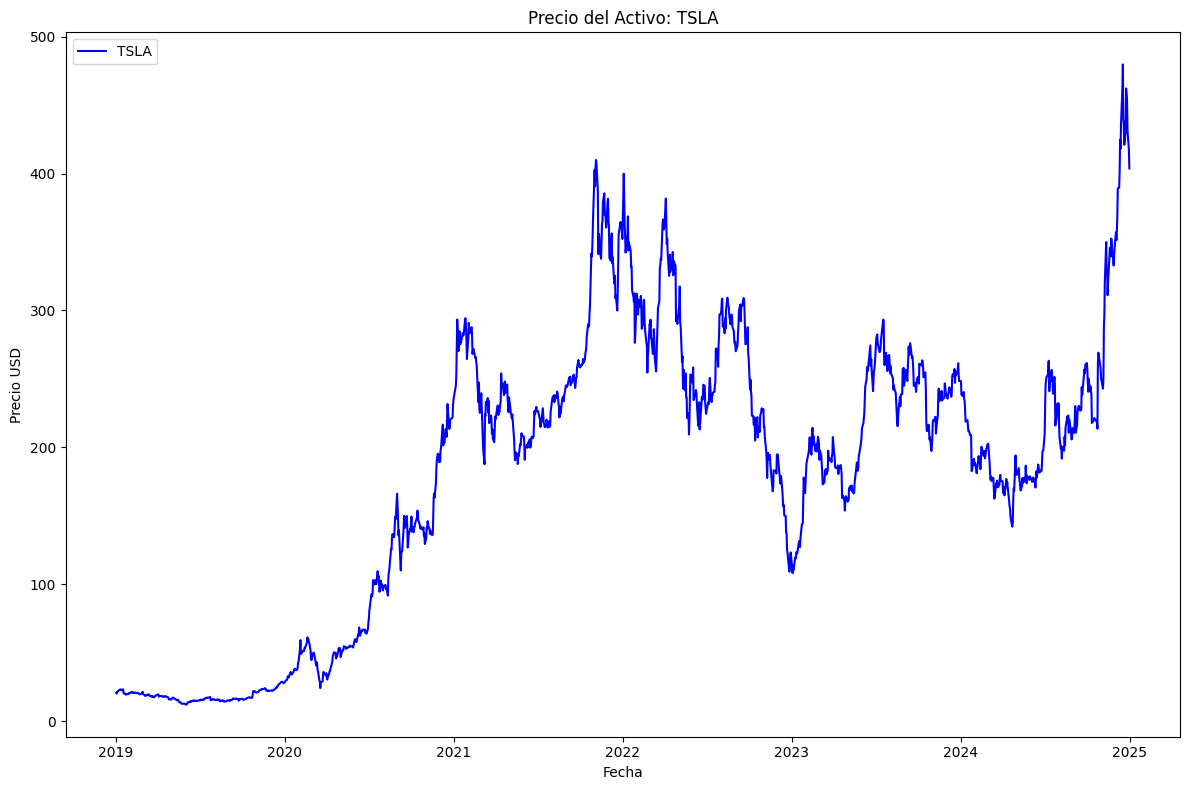

In [9]:
sa = l_simbolos_activos[4]
plt.figure(figsize=(12,8))
#plt.plot(datos_activos[sa],label = sa, color = "red")
plt.plot(precios_activos[sa],label = sa, color = "blue")
plt.xlabel('Fecha')
plt.ylabel('Precio USD')
plt.title(f'Precio del Activo: {sa}')
plt.legend()
plt.tight_layout()
plt.show()

A partir de los precios diarios de cada activo, existen dos maneras de calcular los rendimientos de un activo o portafolio: 

* Retornos simples:
\begin{equation}
    R_i(t+1) = \frac{P_{t+1} - P_t}{P_t}
\end{equation}
* Retornos logarítmicos:
\begin{equation}
    R_i(t+1) = \ln{\left(\frac{P_{t+1}}{P_t}\right)}
\end{equation}

donde $P_t$ representa el precio de cierre del activo $i$ en el día $t$.

comparando se puede notar que los retornos que arrojan son aproximadamente iguales para variaciones pequeñas en el precio. Sin embargo, en este trabajo se emplean los retornos logarítmicos debido a varias ventajas teóricas y 

* Permiten que los rendimientos de varios periodos se pueden sumar directamente, lo cual facilita el análisis de series de tiempo y el cálculo de retornos acumulados.
* Asumen una distribución más cercana a la normalidad, lo que nos permite obtener fácilmente la rentabilidad esperada de cada activo simplemente calculando la media.
* Son independientes de la unidad de medida del precio.

Por estas ventajas se recomienda en \cite{berggrun2011introduccion} que es conveniente calcular los rendimientos utilizados en el análisis se calcularon en su forma logarítmica, a partir de los precios diarios de cierre de cada activo. Generando la distribución de los retornos diarios (véase la Figura~\ref{fig:retornos}).

In [10]:
#retornos_dia = datos_activos.pct_change() #Retornos simples
retornos = np.log(precios_activos / precios_activos.shift(1))
retornos.head()

,AAPL,MSFT,GOOG,AMZN,TSLA
Date,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.104924,-0.037482,-0.028898,-0.025566,-0.031978
2019-01-04,0.041803,0.045460,0.052390,0.048851,0.056094
2019-01-07,-0.002228,0.001274,-0.002169,0.033777,0.052935
2019-01-08,0.018884,0.007225,0.007358,0.016476,0.001164


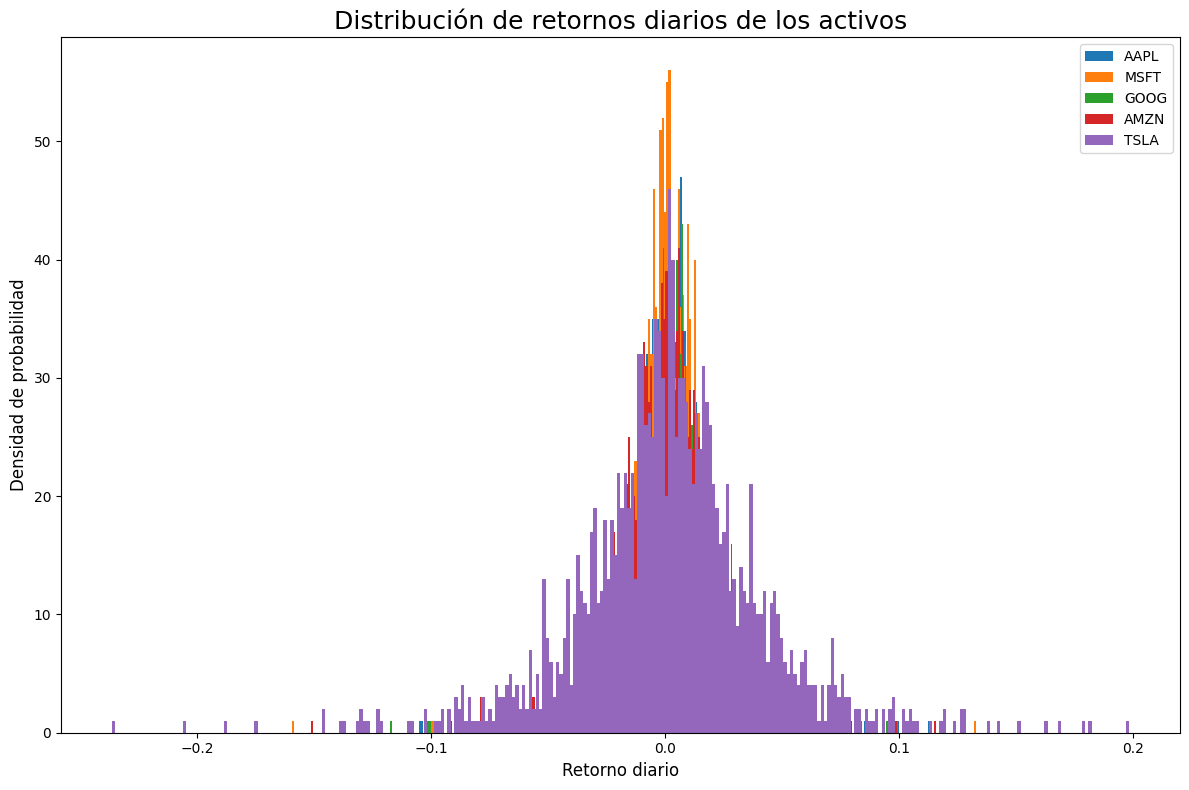

In [11]:
plt.figure(figsize=(12,8))
#plt.plot(df,label = l_simbolos_activos )
for i in  l_simbolos_activos:
    plt.hist(retornos[i], label = i, bins = 300)
plt.xlabel("Retorno diario",fontsize=12)
plt.ylabel("Densidad de probabilidad",fontsize=12)
plt.title("Distribución de retornos diarios de los activos",fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(f"/kaggle/working/Distribucion_Retornos_Diarios_Activos.png",bbox_inches="tight")
plt.show()

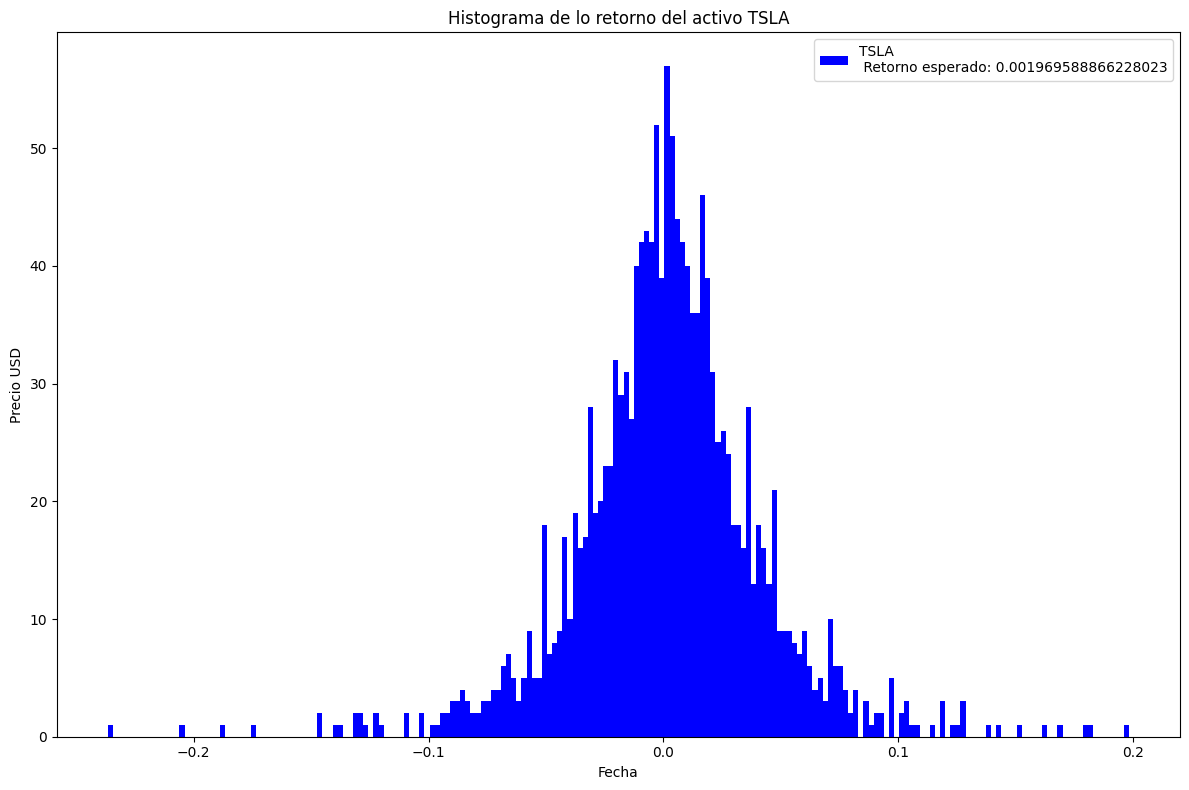

In [12]:
sa = l_simbolos_activos[4]
plt.figure(figsize=(12,8))
plt.hist(retornos[sa], label = sa + f"\n Retorno esperado: {retornos[sa].mean()}", bins = 200, color = "blue")
plt.xlabel('Fecha')
plt.ylabel('Precio USD')
plt.title(f'Histograma de lo retorno del activo {sa}')
plt.legend()
plt.tight_layout()
plt.show()

Analizando la Figura \ref{fig:retornos} observamos que hay un comportamiento aproximado a la una distribución normal, por lo que para el calculo de la rentabilidad esperada de cada activo es conveniente hacerla a través de la media de los retornos diarios los cuales multiplicando por 251, ya que durante el año solo en 251 días se trazan valores\cite{noauthor_undated-jb} (véase la Tabla~\ref{tab:rentabilidades}).

A partir de los datos en la Tabla \ref{tab:rentabilidades} podemos generar nuestro vector de rentabilidades esperadas $\mu$.

In [13]:
mu = retornos.mean()*251
mu

AAPL    0.314915
MSFT    0.247287
GOOG    0.215582
AMZN    0.174255
TSLA    0.494367
dtype: float64

Con los retornos diarios podemos obtener la matriz de covarianzas $\Sigma$ la cual anualizamos de igual forma que la rentabilidad esperada de cada activo (véase la Figura~\ref{fig:covarianzas}).

In [14]:
cov = retornos.cov()*251
cov

,AAPL,MSFT,GOOG,AMZN,TSLA
AAPL,0.094746,0.065684,0.061395,0.062127,0.093787
MSFT,0.065684,0.083883,0.066197,0.067432,0.081947
GOOG,0.061395,0.066197,0.096802,0.068883,0.078180
AMZN,0.062127,0.067432,0.068883,0.115989,0.092800
TSLA,0.093787,0.081947,0.078180,0.092800,0.412283


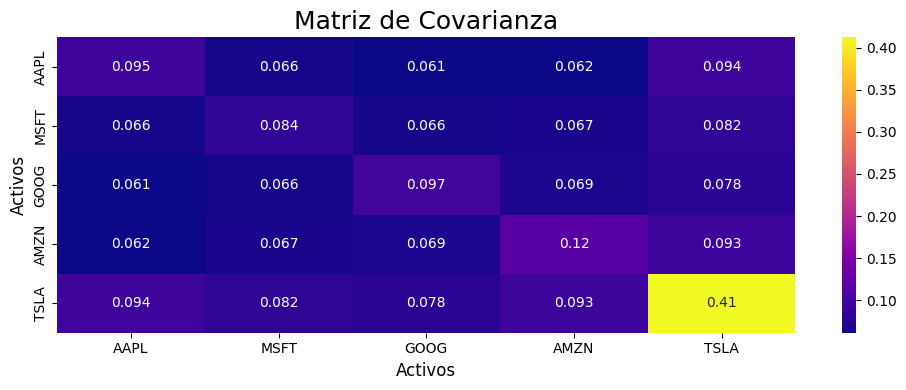

In [15]:
plt.figure(figsize=(10,4))
sns.heatmap(cov, annot = True,cmap='plasma')
plt.xlabel('Activos',fontsize=12)
plt.ylabel('Activos',fontsize=12)
plt.title('Matriz de Covarianza',fontsize=18)
plt.tight_layout()
plt.savefig(f"/kaggle/working/Matriz_Covarianza_Activos.png",bbox_inches="tight")
plt.show()

Algo importante también es la tasa libre de riesgo esta tasa ya que nuestros activos son empresas que reciden en Estados Unidos debe corresponder a bonos del gobierno a largo plazo, en este caso, el bono a 10 años obtenido de \cite{us10ybond}.

In [16]:
rf = 0.04151

Como ya tenemos todos los parámetros de nuestro problema ahora la cuestión es encontrar $\omega$ la proporción del capital a invertir en cada activo que nos genere el portafolio mas optimo.

## Calculo y visualización de la correlación

In [17]:
corr = retornos.corr()
corr

,AAPL,MSFT,GOOG,AMZN,TSLA
AAPL,1.000000,0.736786,0.641081,0.592636,0.474532
MSFT,0.736786,1.000000,0.734616,0.683624,0.440655
GOOG,0.641081,0.734616,1.000000,0.650073,0.391339
AMZN,0.592636,0.683624,0.650073,1.000000,0.424365
TSLA,0.474532,0.440655,0.391339,0.424365,1.000000


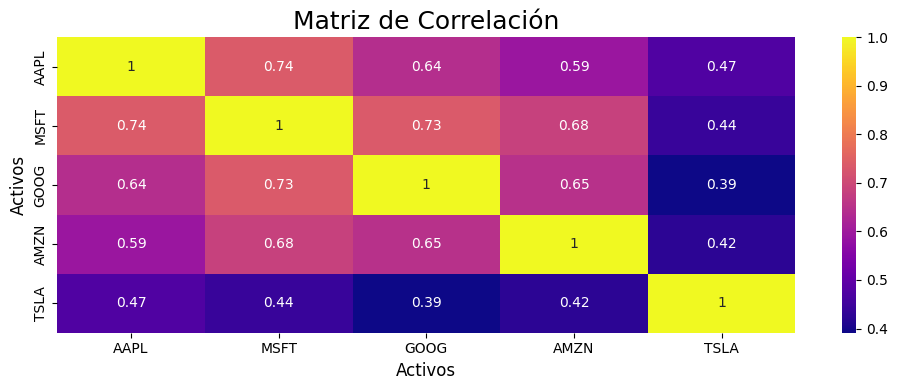

In [18]:
plt.figure(figsize=(10,4))
sns.heatmap(corr, annot = True,cmap='plasma')
plt.xlabel('Activos',fontsize=12)
plt.ylabel('Activos',fontsize=12)
plt.title('Matriz de Correlación',fontsize=18)
plt.tight_layout()
plt.savefig(f"/kaggle/working/Matriz_Correlacion_Activos.png",bbox_inches="tight")
plt.show()

## Método de Simulación Monte Carlo (SMC)

### Implementación del Método de Monte Carlo

El procedimiento general puede describirse de la siguiente manera:

1. Generar aleatoriamente vectores de pesos $\omega$ que cumplan las restricciones del portafolio ($l^T\omega = 1$ y $\omega \geq 0$).
2. Evaluar para cada conjunto de pesos el valor del ratio de Sharpe.
3. Repetir el proceso de generación y evaluación para construir una familia de posibles portafolios.
4. Seleccionar el portafolio que maximice el ratio de Sharpe.

Las simulaciones de Monte Carlo que se realizaron con un total de $30000$ vectores de pesos $\omega$, garantizando una exploración adecuada del espacio de soluciones factibles.

#### Parametros de simulación

In [19]:
num_simul_portfs = 30000
np.random.seed(42)

#### Preparamos vectores y matrices de almacenamiento

In [20]:
w_SMC_arr = np.zeros((num_simul_portfs, len(l_simbolos_activos)))
mu_p_SMC_arr = np.zeros(num_simul_portfs)
var_p_SMC_arr = np.zeros(num_simul_portfs)
sharpe_SMC_arr = np.zeros(num_simul_portfs)

#### Simulación Monte Carlo

In [21]:
inicio = time.time()
lim = num_simul_portfs

for i in range(num_simul_portfs):
    print(bP(i, lim, inicio, f"Simulacion {i}:"), end = "\r")
    if i == num_simul_portfs-1:
          lim = i
          print(bP(i, lim, inicio, f"✅ {i+1} Simulaciones Finalizadas:"), end = "\n\n")
    
    #Pesos aleatorios
    w_SMC = np.random.random(len(l_simbolos_activos))
    w_SMC = w_SMC/np.sum(w_SMC)
    w_SMC_arr[i,:] = w_SMC

    #Rendimiento esperaso
    mu_p_SMC = np.sum(mu.T * w_SMC)
    mu_p_SMC_arr[i] = mu_p_SMC

    #Varianza
    var_p_SMC = np.sqrt(w_SMC.T.dot(cov.dot(w_SMC)))
    var_p_SMC_arr[i] = var_p_SMC

    #Ratio Sharpe
    sharpe_SMC_arr[i] = (mu_p_SMC-rf)/var_p_SMC

✅ 30000 Simulaciones Finalizadas: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.00% 00:00:08:481



#### Resultados por Método de Simulación de Monte Carlo

In [22]:
op_id_SMC = sharpe_SMC_arr.argmax()
op_w_SMC = w_SMC_arr[op_id_SMC,:]
op_mu_p_SMC = mu_p_SMC_arr[op_id_SMC]
op_var_p_SMC = var_p_SMC_arr[op_id_SMC]
op_sharpe_SMC = sharpe_SMC_arr[op_id_SMC]

In [23]:
print(f"Retorno Esperado: {op_mu_p_SMC*100:.2f}%")
print(f"Volatilidad: {op_var_p_SMC*100:.2f}%")
print(f"Ratio de Sharpe: {op_sharpe_SMC:.4f}")
print("\nPesos óptimos:")
for activo, w in sorted(zip(l_simbolos_activos, op_w_SMC), key=lambda x: x[1], reverse=True):
    print(f"{activo}: {w*100:.2f}%")

Retorno Esperado: 35.54%
Volatilidad: 33.34%
Ratio de Sharpe: 0.9415

Pesos óptimos:
AAPL: 73.65%
TSLA: 23.90%
GOOG: 2.18%
MSFT: 0.23%
AMZN: 0.04%


## Método de Programación Cuadrática (QP)

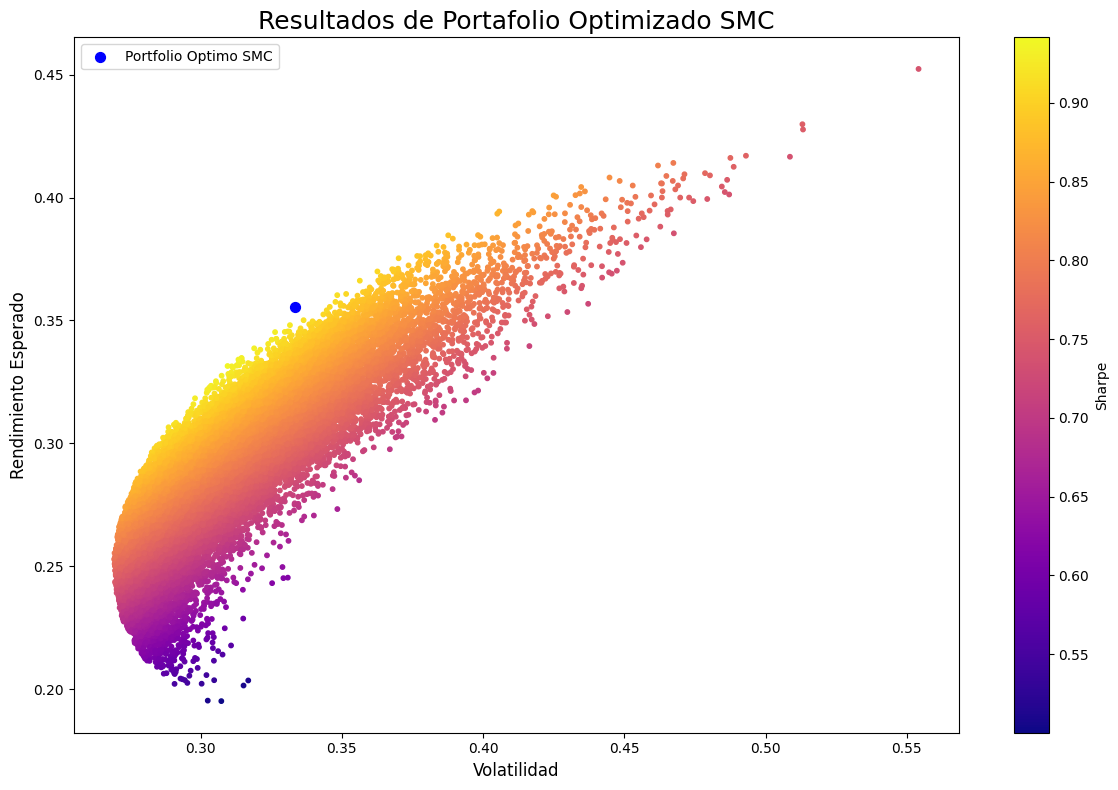

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(var_p_SMC_arr, mu_p_SMC_arr, c=sharpe_SMC_arr, cmap='plasma', marker='o', s=10)
plt.colorbar(label='Sharpe')
plt.scatter(op_var_p_SMC, op_mu_p_SMC, color='blue', marker='.', s=200, label='Portfolio Optimo SMC')
plt.xlabel('Volatilidad',fontsize=12)
plt.ylabel('Rendimiento Esperado',fontsize=12)
plt.title('Resultados de Portafolio Optimizado SMC',fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(f"/kaggle/working/Resultados_Portafolio_Optimo_SMC.png",bbox_inches="tight")
plt.show()

#### Solución de caso especial de problema de programación cuadráticas por método de multiplicadores de Lagrange (QPS)

\begin{align*}
    \min \quad & \frac{1}{2}\omega^T\Sigma \omega \\
    \text{s.a.} \quad & \mu^T\omega = \mu_p \\
    & l^T\omega = 1 \\
\end{align*}

Obtenemos el lagrangenao del sistema

$$L(w,\lambda_1,\lambda_2) = \frac{1}{2}\omega^T\Sigma \omega - \lambda_1(\mu^T\omega - \mu_p) - \lambda_2(l^T\omega - 1)$$

Al aplicar las condiciones de primer orden, 

$$ \nabla_\omega L = \Sigma \omega - \lambda_1\mu - \lambda_2l = 0$$
$$ \nabla_{\lambda_1} L = \mu^T\omega - \mu_p = 0$$
$$ \nabla_{\lambda_2} L = l^T\omega - 1 = 0$$

se obtiene el siguiente sistema lineal de ecuaciones

\begin{align*}
    \Sigma \omega - \lambda_1\mu - \lambda_2l &= 0\\
     \mu^T\omega - \mu_p &= 0\\
     l^T\omega - 1 &= 0\\
\end{align*}


procedimiente de solucion en 

@misc{barrera2008optimizacion,
  title={Optimizaci{\'o}n de Portafolios},
  author={Barrera, Patricia Saavedra},
  year={2008},
  publisher={Iztapalapa}
}

Resolviendo el sistema

$$ \omega = \lambda_1 \Sigma^{-1} \mu + \lambda_2 \Sigma^{-1} l $$

Al substituir w se obtiene el siguiente sistema de ecuaciones para $\lambda_1$ y $\lambda_2$

\begin{align*}
    \lambda_1 \mu^T \Sigma^{-1} \mu + \lambda_2 \mu^T \Sigma^{-1} l &= \mu_p\\
    \lambda_1 l^T \Sigma^{-1} \mu + \lambda_2 l^T \Sigma^{-1} l &= 1\\
\end{align*}

donde renombramos a

$$A = \mu^T \Sigma^{-1} \mu,\qquad B = \mu^T \Sigma^{-1} l,\qquad C = l^T \Sigma^{-1} l$$

entonces

\begin{align*}
    A\lambda_1 + B\lambda_2 &= \mu_p\\
    B\lambda_1 + C\lambda_2 &= 1\\
\end{align*}

la solucion a este sistema es

$$ D = AC-B^2$$

$$ \lambda_1 =\frac{C\mu_p-B}{D},\qquad \lambda_2 = \frac{A-B\mu_p}{D} $$

Entonces la varianza del protafolio minimo es

$$ \sigma_p^2 = \omega^T \Sigma \omega = \omega^T \Sigma (\lambda_1 \Sigma^{-1} \mu + \lambda_2 \Sigma^{-1} l ) $$
$$ \sigma_p^2 =\omega^T [\lambda_1 \mu + \lambda_2 l ]$$
$$ \sigma_p^2 = \lambda_1 \omega^T\mu + \lambda_2 \omega^Tl$$

aplicando algunas de nuestras restriciónes y sustitullendo $\lambda_1$ y $\lambda_2$

$$ \sigma_p^2 = \lambda_1 \mu_p + \lambda_2$$
$$ \sigma_p^2 = \left[ \frac{C\mu_p-B}{D} \right] \mu_p + \frac{A-B\mu_p}{D} $$
$$ \sigma_p^2 = \frac{C\mu_p^2-2B\mu_p+A}{D} $$

#### Calculando frontera eficiente

In [25]:
inv_cov = np.linalg.inv(cov)
l_QPS = np.ones(len(l_simbolos_activos))
A_QPS = mu.T.dot(inv_cov).dot(mu)
B_QPS = mu.T.dot(inv_cov).dot(l_QPS)
C_QPS = l_QPS.T.dot(inv_cov).dot(l_QPS)
D_QPS = A_QPS*C_QPS-B_QPS**2
mu_p_QPS = np.linspace(min(mu_p_SMC_arr), max(mu_p_SMC_arr),1000)

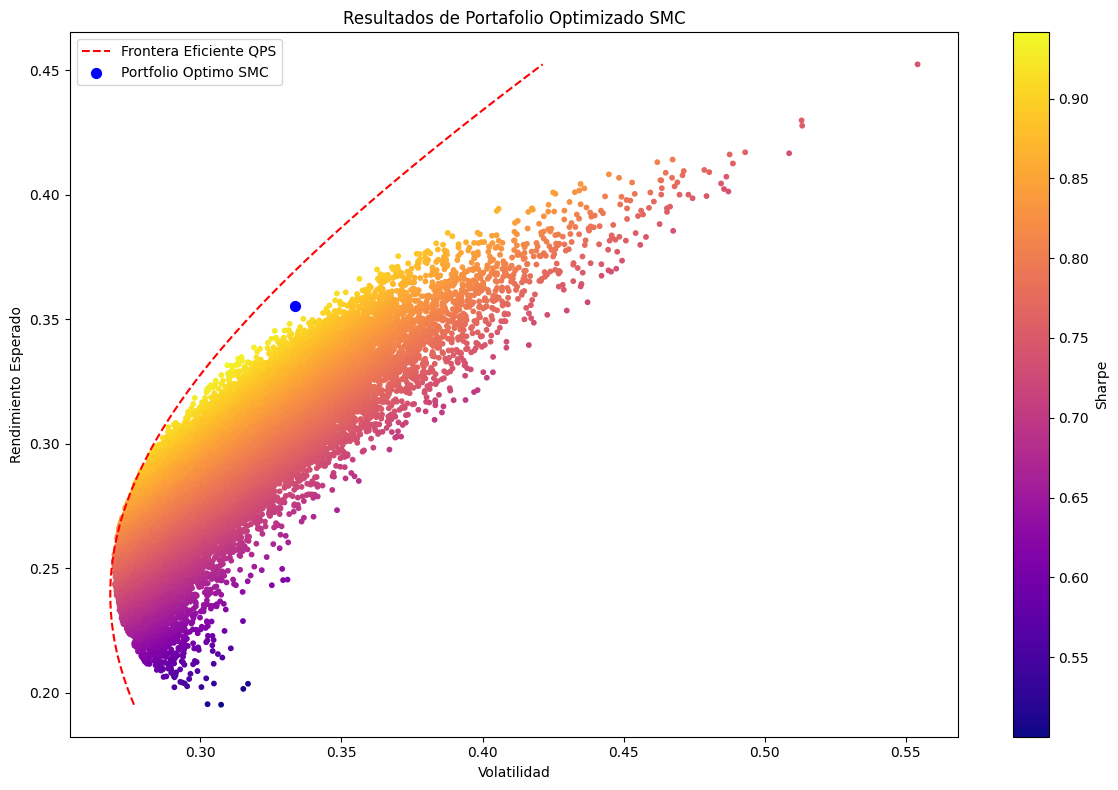

In [26]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt((C_QPS*(mu_p_QPS)**2 - 2*B_QPS*mu_p_QPS + A_QPS)/(D_QPS)),mu_p_QPS,"r--", label="Frontera Eficiente QPS")
plt.scatter(var_p_SMC_arr, mu_p_SMC_arr, c=sharpe_SMC_arr, cmap='plasma', marker='o', s=10)
plt.colorbar(label='Sharpe')
plt.scatter(op_var_p_SMC, op_mu_p_SMC, color='blue', marker='.', s=200, label='Portfolio Optimo SMC')
plt.xlabel('Volatilidad')
plt.ylabel('Rendimiento Esperado')
plt.title('Resultados de Portafolio Optimizado SMC')
plt.legend()
plt.tight_layout()
plt.show()

### Método de Programación Cuadrática minimizando ratio de Sharpe (QP)

\begin{align}
    \min \quad & \frac{1}{2}\omega^T\Sigma \omega \\
    \text{s.a.} \quad & \mu^T\omega - R_f = \mu_p^* \\
    & l^T\omega = 1 \\
    & \omega \geq 0
\end{align}

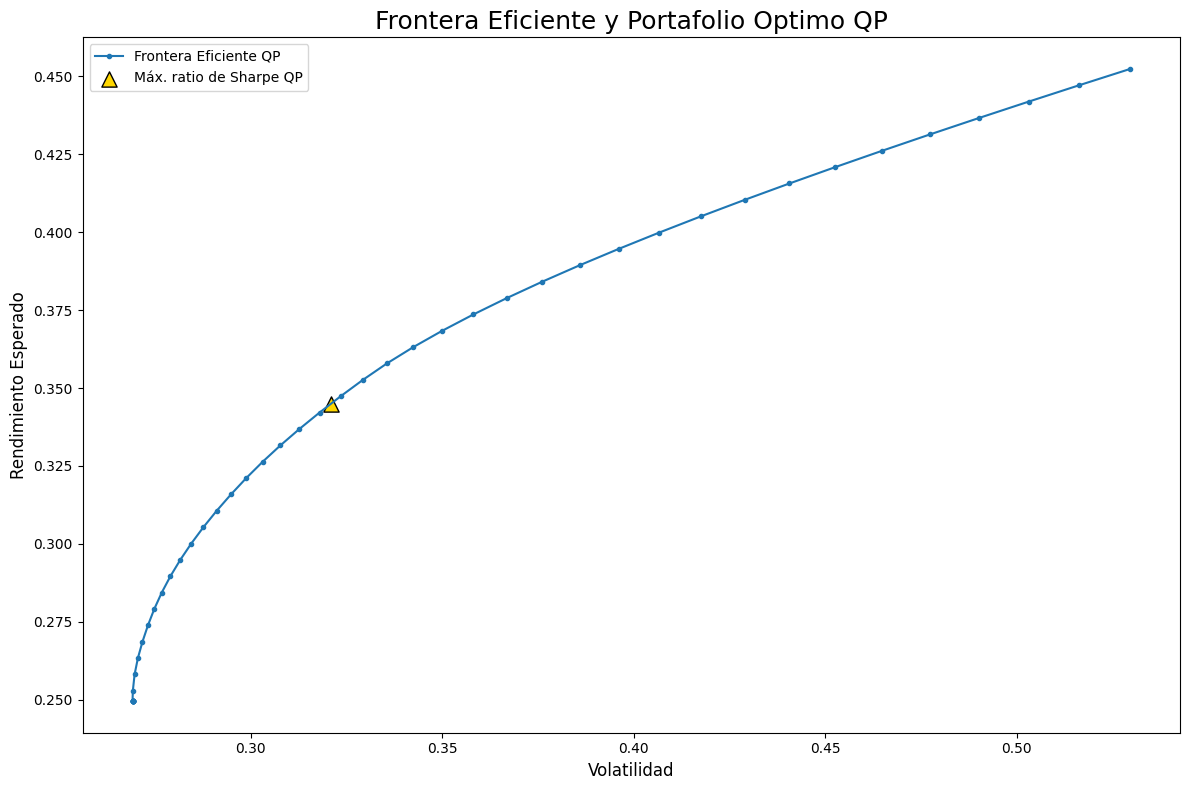

In [27]:
# --- Configuración de fronteras ---
ef = EfficientFrontier(mu, cov, weight_bounds=(0, 1))

# Portafolio de mínima volatilidad
ef_min = EfficientFrontier(mu, cov, weight_bounds=(0, 1))
ef_min.min_volatility()
min_return, min_risk, _ = ef_min.portfolio_performance(verbose=False)

# Portafolio de máxima Sharpe
ef_max = EfficientFrontier(mu, cov, weight_bounds=(0.001, 1))
ef_max.max_sharpe(risk_free_rate=rf)
max_return, max_risk, max_sharpe = ef_max.portfolio_performance(risk_free_rate=rf, verbose=False)

# 📊 Extraer los pesos óptimos del portafolio con máximo Sharpe ratio
weights_max_sharpe = ef_max.clean_weights(cutoff=1e-6)  # limpia los valores muy pequeños a 0
weights_df = pd.DataFrame.from_dict(weights_max_sharpe, orient='index', columns=['Peso óptimo'])

# Construimos rango de retornos factibles entre los dos extremos
target_returns = np.linspace(min(mu_p_SMC_arr), max(mu_p_SMC_arr), 50)

rets, risks = [], []

for r in target_returns:
    ef = EfficientFrontier(mu, cov, weight_bounds=(0, 1))
    ef.efficient_return(target_return=r)
    ret, risk, _ = ef.portfolio_performance(verbose=False)
    rets.append(ret)
    risks.append(risk)

# --- Gráfica ---
plt.figure(figsize=(12,8))
plt.plot(risks, rets, '-o', ms=3, label='Frontera Eficiente QP')

# Punto del portafolio de mínima varianza
#plt.scatter(min_risk, min_return, c='red', s=80, marker='o', label='Mínima varianza')

# Punto del portafolio de máxima Sharpe
plt.scatter(max_risk, max_return, c='gold', s=120, edgecolor='black', marker='^', label='Máx. ratio de Sharpe QP')

# Línea del mercado de capital (CML)
#x = np.linspace(min(varianza_arr), max(risks), 50)
#plt.plot(x, rf + max_sharpe * (x - 0), 'k--', label='Línea del mercado de capital')
plt.xlabel('Volatilidad',fontsize=12) 
plt.ylabel('Rendimiento Esperado',fontsize=12) 
plt.title('Frontera Eficiente y Portafolio Optimo QP',fontsize=18) 
plt.legend()
plt.tight_layout() 
plt.savefig(f"/kaggle/working/Frontera_Eficiente_Optimo_QP.png",bbox_inches="tight")
plt.legend()
plt.show()

In [28]:
print(f"Retorno Esperado: {max_return*100:.2f}%")
print(f"Volatilidad: {max_risk*100:.2f}%")
print(f"Ratio de Sharpe: {max_sharpe:.4f}")
print("\nPesos óptimos:")
for activo, w in sorted(zip(l_simbolos_activos, weights_df.iloc[:,0]), key=lambda x: x[1], reverse=True):
    print(f"{activo}: {w*100:.2f}%")

Retorno Esperado: 34.49%
Volatilidad: 32.10%
Ratio de Sharpe: 0.9453

Pesos óptimos:
AAPL: 74.93%
TSLA: 19.05%
MSFT: 5.82%
GOOG: 0.10%
AMZN: 0.10%


### SMC vs QP

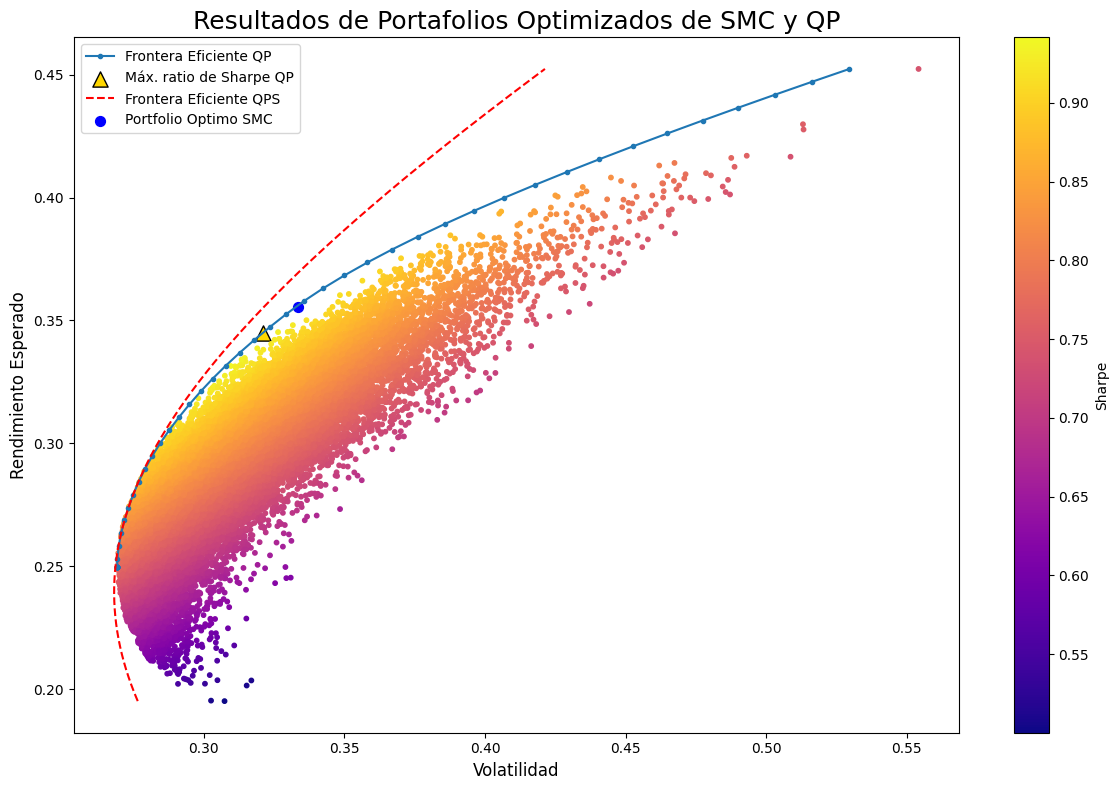

In [29]:
plt.figure(figsize=(12,8))
plt.plot(risks, rets, '-o', ms=3, label='Frontera Eficiente QP')
plt.scatter(max_risk, max_return, c='gold', s=120, edgecolor='black', marker='^', label='Máx. ratio de Sharpe QP')
plt.plot(np.sqrt((C_QPS*(mu_p_QPS)**2 - 2*B_QPS*mu_p_QPS + A_QPS)/(D_QPS)),mu_p_QPS,"r--", label="Frontera Eficiente QPS")
plt.scatter(var_p_SMC_arr, mu_p_SMC_arr, c=sharpe_SMC_arr, cmap='plasma', marker='o', s=10)
plt.colorbar(label='Sharpe')
plt.scatter(op_var_p_SMC, op_mu_p_SMC, color='blue', marker='.', s=200, label='Portfolio Optimo SMC')
plt.xlabel('Volatilidad',fontsize=12)
plt.ylabel('Rendimiento Esperado',fontsize=12)
plt.title('Resultados de Portafolios Optimizados de SMC y QP',fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(f"/kaggle/working/Resultados_Portafolios_Optimizados_SMC_vs_QP.png",bbox_inches="tight")
plt.show()

## Método de Algoritmo Genético (AG)

### Implementación del Algoritmo Genético

El algoritmo genético se implementó completamente en Python, con el fin de tener un mayor control sobre los parámetros evolutivos y el proceso de optimización. 
La población inicial se genera mediante vectores aleatorios de pesos $\omega$, los cuales son reparados para cumplir las restricciones $\sum_i \omega_i = 1$ y $\omega_i \ge 0$ mediante una función de normalización (\texttt{repair\_weights}).

La función objetivo corresponde al \textbf{ratio de Sharpe}, definido como:

\begin{equation}
    f(\omega) = \frac{\mu^T\omega - R_f}{\sqrt{\omega^T \Sigma \omega}}
\end{equation}

donde se busca su maximización. El proceso evolutivo utiliza los siguientes operadores:

- **Selección por torneo:** se eligen aleatoriamente \( k = 3 \) individuos, seleccionando el que posea mayor valor de *fitness*.  
- **Cruce lineal:** se combinan dos padres \( p_1 \) y \( p_2 \) de acuerdo con  
  \[
  h = \alpha p_1 + (1 - \alpha)p_2, \quad \alpha \sim U(0,1)
  \]
- **Mutación gaussiana:** se perturba cada gen con una distribución \( \mathcal{N}(0,\sigma) \) con probabilidad \( p_m = 0.2 \) y \( \sigma = 0.05 \).  
- **Elitismo:** los \( 5 \) mejores individuos de cada generación son preservados.  

Los parámetros empleados se resumen en la Tabla~\ref{tab:param_ga}.

| Parámetro | Valor |
|:-----------|:------:|
| Tamaño de población | 100 |
| Número de generaciones | 300 |
| Probabilidad de cruce | 0.8 |
| Probabilidad de mutación | 0.2 |
| Desviación estándar de mutación \( \sigma \) | 0.05 |
| Número de élites | 5 |
| Tamaño del torneo \( k \) | 3 |

El proceso de evolución se detiene tras 300 generaciones o cuando el mejor valor de fitness no mejora en varias iteraciones consecutivas.
Durante la ejecución se registra el mejor ratio de Sharpe por generación, lo que permite analizar la convergencia del algoritmo (véase la Figura~\ref{fig:evolucion_ga}).

In [30]:
TICKERS = l_simbolos_activos
RISK_FREE = rf
n_assets = len(TICKERS)

#### Funciones Auxiliares

In [31]:
def repair_weights(w: np.ndarray) -> np.ndarray:
    """Ajusta pesos a no negativos y que sumen 1."""
    w = np.clip(w, 0, None)
    return w / w.sum() if w.sum() != 0 else np.ones_like(w) / len(w)

def portfolio_stats(weights, mu, cov, rf=0.0):
    """Calcula rendimiento, volatilidad y ratio de Sharpe."""
    w = np.array(weights)
    ret = w @ mu
    vol = np.sqrt(w @ cov @ w)
    sharpe = (ret - rf) / vol if vol > 0 else 0
    return ret, vol, sharpe

### Algoritmo Genético

In [32]:

GA_PARAMS = {
    "pop_size": 100,
    "n_generations": 300,
    "cx_prob": 0.8,
    "mut_prob": 0.2,
    "mut_sigma": 0.05,
    "elite_size": 5,
    "tournament_k": 3,
}

def init_population(size, n_assets):
    """Inicializa una población de pesos válidos."""
    return np.array([repair_weights(np.random.rand(n_assets)) for _ in range(size)])

def fitness(weights, mu, cov, rf):
    """Función objetivo: maximizar Sharpe."""
    return portfolio_stats(weights, mu, cov, rf)[2]

def tournament_selection(pop, fitnesses, k):
    """Selecciona el mejor individuo de un torneo aleatorio."""
    idx = np.random.choice(len(pop), k, replace=False)
    return pop[idx[np.argmax(fitnesses[idx])]].copy()

def crossover(p1, p2):
    """Cruce lineal entre dos padres."""
    alpha = np.random.rand(len(p1))
    return repair_weights(alpha * p1 + (1 - alpha) * p2)

def mutate(ind, sigma=0.05, prob=0.2):
    """Aplica mutación gaussiana."""
    if np.random.rand() < prob:
        ind = repair_weights(ind + np.random.normal(0, sigma, ind.shape))
    return ind

def run_ga(mu, cov, rf, params=GA_PARAMS, generations=None):
    """Ejecuta el algoritmo genético y retorna el mejor individuo."""
    pop_size = params["pop_size"]
    n_generations = generations or params["n_generations"]
    pop = init_population(pop_size, len(mu))
    best_history = []

    for gen in range(n_generations):
        fits = np.array([fitness(ind, mu, cov, rf) for ind in pop])
        new_pop = []

        # Elitismo
        elites = pop[np.argsort(fits)[-params["elite_size"]:]]
        new_pop.extend(elites)

        # Reproducción
        while len(new_pop) < pop_size:
            p1 = tournament_selection(pop, fits, params["tournament_k"])
            p2 = tournament_selection(pop, fits, params["tournament_k"])
            child = crossover(p1, p2) if np.random.rand() < params["cx_prob"] else p1.copy()
            child = mutate(child, params["mut_sigma"], params["mut_prob"])
            new_pop.append(child)

        pop = np.array(new_pop)
        best_fit = fits.max()
        best_history.append(best_fit)

        if (gen + 1) % 20 == 0:
            print(f"Gen {gen+1:03d} | Best Sharpe: {best_fit:.4f}")

    # Mejor individuo final
    fits = np.array([fitness(ind, mu, cov, rf) for ind in pop])
    best = pop[np.argmax(fits)]
    return best, best_history

### Entrenamiento Principal

In [33]:
best_weights, best_history = run_ga(mu, cov, RISK_FREE)

ret, vol, sharpe = portfolio_stats(best_weights, mu, cov, RISK_FREE)
print("\n=== Mejor Solución GA ===")
for t, w in zip(TICKERS, best_weights):
    print(f"{t:6s}: {w:.4f}")
print(f"Retorno anual esperado: {ret:.2%}")
print(f"Volatilidad anual: {vol:.2%}")
print(f"Ratio de Sharpe: {sharpe:.4f}")

Gen 020 | Best Sharpe: 0.9455
Gen 040 | Best Sharpe: 0.9455
Gen 060 | Best Sharpe: 0.9455
Gen 080 | Best Sharpe: 0.9455
Gen 100 | Best Sharpe: 0.9455
Gen 120 | Best Sharpe: 0.9455
Gen 140 | Best Sharpe: 0.9455
Gen 160 | Best Sharpe: 0.9455
Gen 180 | Best Sharpe: 0.9455
Gen 200 | Best Sharpe: 0.9455
Gen 220 | Best Sharpe: 0.9455
Gen 240 | Best Sharpe: 0.9455
Gen 260 | Best Sharpe: 0.9455
Gen 280 | Best Sharpe: 0.9455
Gen 300 | Best Sharpe: 0.9455

=== Mejor Solución GA ===
AAPL  : 0.7498
MSFT  : 0.0597
GOOG  : 0.0000
AMZN  : 0.0000
TSLA  : 0.1905
Retorno anual esperado: 34.51%
Volatilidad anual: 32.10%
Ratio de Sharpe: 0.9455


#### Evolución del Sharpe

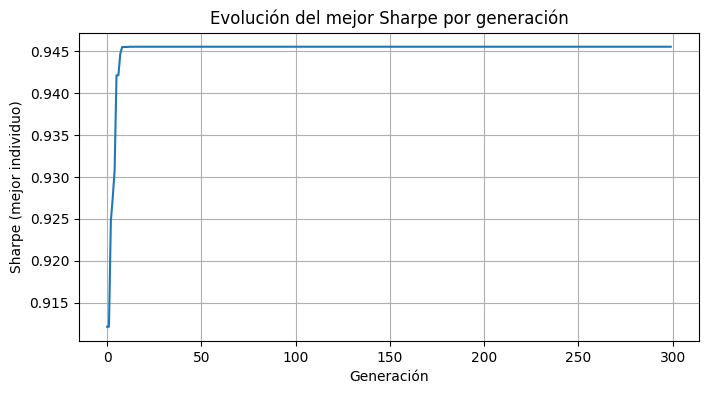

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(best_history)
plt.title("Evolución del mejor Sharpe por generación")
plt.xlabel("Generación")
plt.ylabel("Sharpe (mejor individuo)")
plt.grid(True)
plt.show()

#### Comparación con portafolio equiponderado

In [35]:
w_eq = np.ones(n_assets) / n_assets
ret_eq, vol_eq, sharpe_eq = portfolio_stats(w_eq, mu, cov, RISK_FREE)
print(f"\n=== Portafolio Equiponderado ===")
print(f"Retorno: {ret_eq:.2%} | Vol: {vol_eq:.2%} | Sharpe: {sharpe_eq:.4f}")


=== Portafolio Equiponderado ===
Retorno: 28.93% | Vol: 30.20% | Sharpe: 0.8204


###  FRONTERAS EFICIENTES (Analítica, Muestreo, Exacta)

In [36]:
# A) Frontera analítica (sin restricciones de short-selling)
ones = np.ones(n_assets)
inv_cov = np.linalg.pinv(cov.values)
A = ones @ inv_cov @ ones
B = ones @ inv_cov @ mu.values
C = mu.values @ inv_cov @ mu.values
D = A * C - B**2

target_returns = np.linspace(mu.min(), mu.max(), 200)
analytical_vols = np.sqrt(np.maximum((A * target_returns**2 - 2 * B * target_returns + C) / D, 0))

# B) Frontera aproximada (no short)
n_random = 20000
rand_weights = np.array([repair_weights(np.random.rand(n_assets)) for _ in range(n_random)])
rand_rets = rand_weights @ mu.values
rand_vols = np.sqrt(np.einsum("ij,jk,ik->i", rand_weights, cov.values, rand_weights))
rand_sharpes = (rand_rets - RISK_FREE) / rand_vols

# C) Frontera exacta con CVXPY
try:
    import cvxpy as cp
    mu_grid = np.linspace(rand_rets.min(), rand_rets.max(), 80)
    exact_vols, exact_rets = [], []
    Sigma, mu_vec = cov.values, mu.values

    print("\nCalculando frontera exacta (cvxpy)...")
    for target in mu_grid:
        w = cp.Variable(n_assets)
        constraints = [mu_vec @ w == target, cp.sum(w) == 1, w >= 0]
        prob = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)), constraints)
        prob.solve(solver=cp.OSQP, warm_start=True)
        if w.value is not None:
            wv = repair_weights(np.array(w.value).flatten())
            r, v, _ = portfolio_stats(wv, mu, cov, RISK_FREE)
            exact_rets.append(r)
            exact_vols.append(v)
    exact_vols, exact_rets = np.array(exact_vols), np.array(exact_rets)
except Exception as e:
    print("Error calculando frontera exacta:", e)
    exact_vols, exact_rets = [], []


Calculando frontera exacta (cvxpy)...


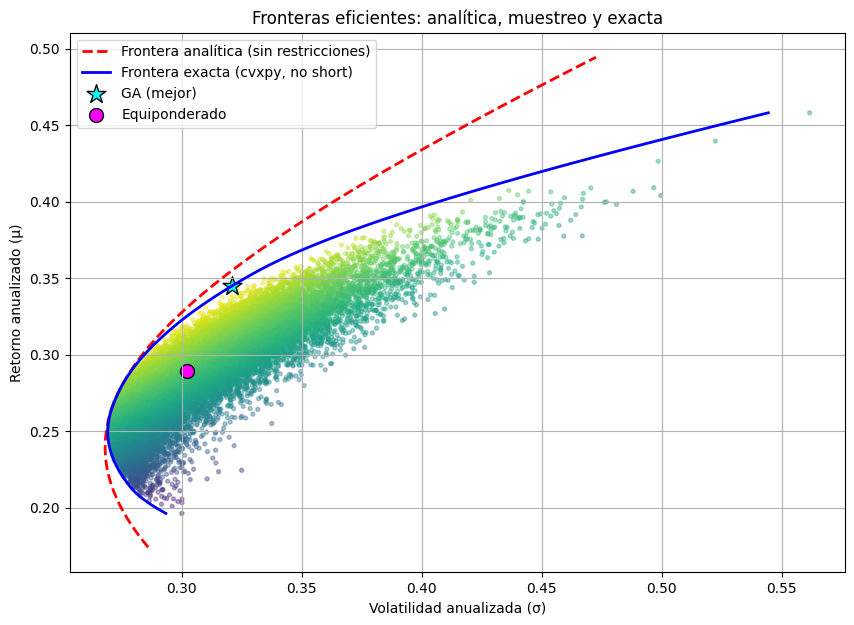

In [37]:
# Gráfico fronteras
plt.figure(figsize=(10, 7))
plt.scatter(rand_vols, rand_rets, c=rand_sharpes, cmap="viridis", s=8, alpha=0.4)
plt.plot(analytical_vols, target_returns, "r--", lw=2, label="Frontera analítica (sin restricciones)")
if len(exact_vols):
    plt.plot(exact_vols, exact_rets, "b", lw=2, label="Frontera exacta (cvxpy, no short)")
plt.scatter(vol, ret, marker="*", s=200, c="cyan", edgecolor="k", label="GA (mejor)")
plt.scatter(vol_eq, ret_eq, marker="o", s=100, c="magenta", edgecolor="k", label="Equiponderado")
plt.title("Fronteras eficientes: analítica, muestreo y exacta")
plt.xlabel("Volatilidad anualizada (σ)")
plt.ylabel("Retorno anualizado (μ)")
plt.legend()
plt.grid(True)
plt.show()

### GRÁFICO paper GA Nube de portafolios

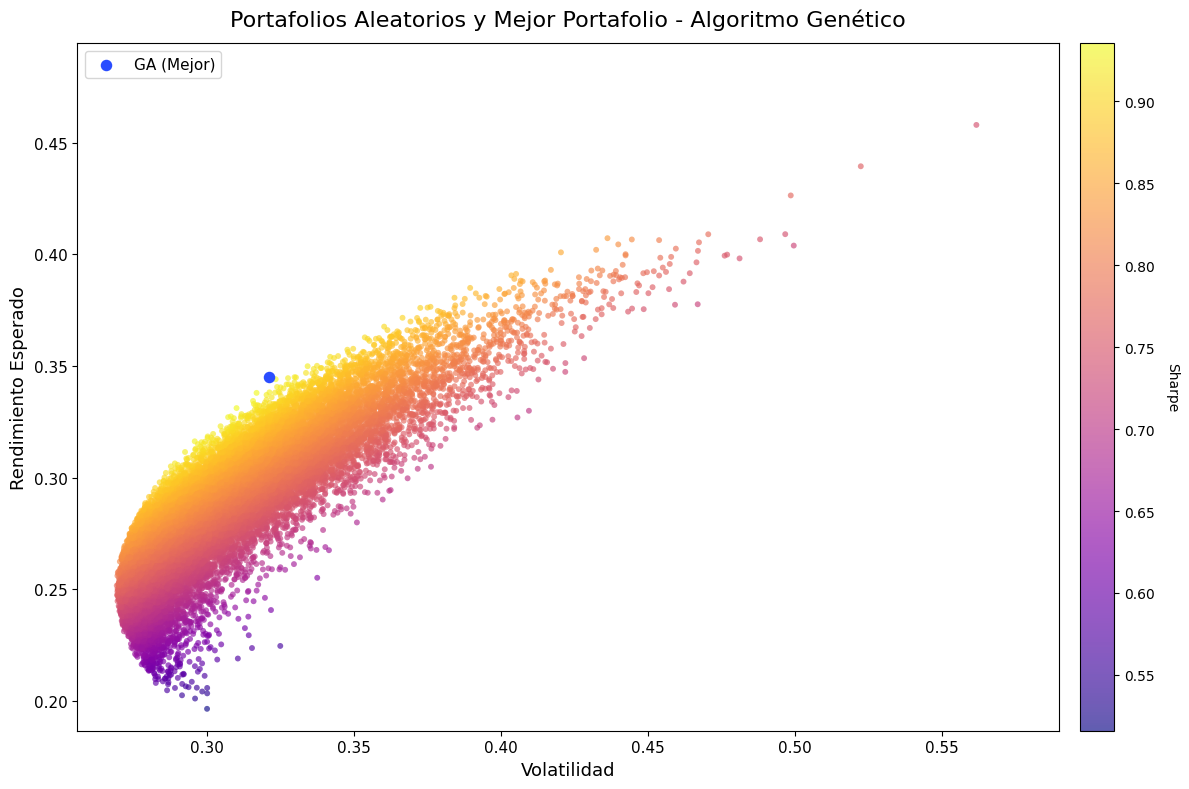

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

# Nube de portafolios aleatorios (color por Sharpe)
sc = ax.scatter(rand_vols, rand_rets,
                c=rand_sharpes,
                cmap="plasma",
                s=18,
                alpha=0.65,
                edgecolors="none")

# Punto del mejor portafolio GA
ax.scatter(vol, ret,
#           marker="*",
           s=50,
           c="#2a4dff",
#           edgecolor="k",
           linewidth=1.2,
           label="GA (Mejor)")

# Etiquetas y título
ax.set_title("Portafolios Aleatorios y Mejor Portafolio - Algoritmo Genético", fontsize=16, pad=12)
ax.set_xlabel("Volatilidad", fontsize=13)
ax.set_ylabel("Rendimiento Esperado", fontsize=13)

# Colorbar
cbar = fig.colorbar(sc, ax=ax, fraction=0.036, pad=0.02)
cbar.set_label("Sharpe", rotation=270, labelpad=18)

# Leyenda y formato
ax.legend(loc="upper left", frameon=True, fontsize=11)
ax.tick_params(axis="both", which="major", labelsize=11)
ax.set_xlim(left=max(0, rand_vols.min() * 0.95), right=rand_vols.max() * 1.05)
ax.set_ylim(bottom=rand_rets.min() * 0.95, top=rand_rets.max() * 1.08)
plt.tight_layout()
plt.savefig(f"/kaggle/working/Resultados_Portafolio_Optimo_GA.png",bbox_inches="tight")
plt.show()

### VALIDACIÓN WALK-FORWARD

In [39]:
returns = retornos

print("\n=== Validación Walk-Forward ===")
window_size = int(len(returns) * 0.6)
step_size = int(len(returns) * 0.1)
cv_results, start, fold = [], 0, 1

while start + window_size + step_size <= len(returns):
    train = returns.iloc[start:start + window_size]
    test = returns.iloc[start + window_size:start + window_size + step_size]

    mu_train, cov_train = train.mean() * 252, train.cov() * 252
    mu_test, cov_test = test.mean() * 252, test.cov() * 252

    best_w, _ = run_ga(mu_train, cov_train, RISK_FREE, generations=100)
    ret_t, vol_t, sharpe_t = portfolio_stats(best_w, mu_test, cov_test, RISK_FREE)
    cv_results.append([ret_t, vol_t, sharpe_t])

    print(f"Fold {fold:02d}: {test.index[0].date()} - {test.index[-1].date()} | Sharpe={sharpe_t:.4f}")
    start += step_size
    fold += 1

cv_results = np.array(cv_results)
mean_ret, mean_vol, mean_sharpe = cv_results.mean(axis=0)
std_sharpe = cv_results[:, 2].std()

print("\nResultados promedio (Walk-Forward):")
print(f"Retorno medio: {mean_ret:.2%}")
print(f"Volatilidad media: {mean_vol:.2%}")
print(f"Sharpe medio: {mean_sharpe:.4f} ± {std_sharpe:.4f}")


=== Validación Walk-Forward ===
Gen 020 | Best Sharpe: 1.2093
Gen 040 | Best Sharpe: 1.2093
Gen 060 | Best Sharpe: 1.2093
Gen 080 | Best Sharpe: 1.2093
Gen 100 | Best Sharpe: 1.2093
Fold 01: 2022-08-08 - 2023-03-14 | Sharpe=-0.9519
Gen 020 | Best Sharpe: 0.9929
Gen 040 | Best Sharpe: 0.9930
Gen 060 | Best Sharpe: 0.9930
Gen 080 | Best Sharpe: 0.9930
Gen 100 | Best Sharpe: 0.9930
Fold 02: 2023-03-15 - 2023-10-18 | Sharpe=1.0682
Gen 020 | Best Sharpe: 0.8168
Gen 040 | Best Sharpe: 0.8168
Gen 060 | Best Sharpe: 0.8168
Gen 080 | Best Sharpe: 0.8168
Gen 100 | Best Sharpe: 0.8168
Fold 03: 2023-10-19 - 2024-05-24 | Sharpe=-0.3016
Gen 020 | Best Sharpe: 0.6278
Gen 040 | Best Sharpe: 0.6278
Gen 060 | Best Sharpe: 0.6278
Gen 080 | Best Sharpe: 0.6278
Gen 100 | Best Sharpe: 0.6278
Fold 04: 2024-05-28 - 2024-12-31 | Sharpe=0.0499

Resultados promedio (Walk-Forward):
Retorno medio: 0.99%
Volatilidad media: 28.10%
Sharpe medio: -0.0339 ± 0.7307


### GA vs QP

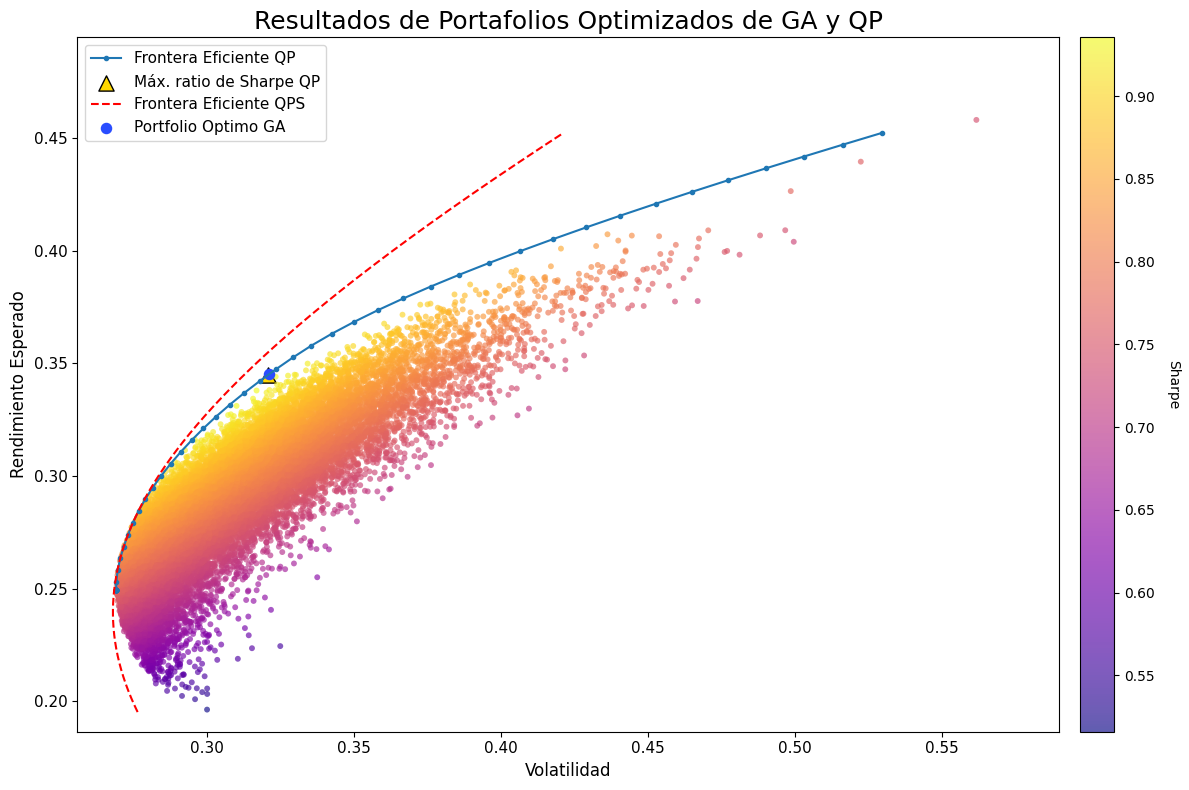

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(risks, rets, '-o', ms=3, label='Frontera Eficiente QP')
plt.scatter(max_risk, max_return, c='gold', s=120, edgecolor='black', marker='^', label='Máx. ratio de Sharpe QP')
plt.plot(np.sqrt((C_QPS*(mu_p_QPS)**2 - 2*B_QPS*mu_p_QPS + A_QPS)/(D_QPS)),mu_p_QPS,"r--", label="Frontera Eficiente QPS")

# Nube de portafolios aleatorios (color por Sharpe)
sc = ax.scatter(rand_vols, rand_rets,
                c=rand_sharpes,
                cmap="plasma",
                s=18,
                alpha=0.65,
                edgecolors="none")

# Punto del mejor portafolio GA
ax.scatter(vol, ret,
#           marker="*",
           s=50,
           c="#2a4dff",
#           edgecolor="k",
           linewidth=1.2,
           label="Portfolio Optimo GA")

# Etiquetas y título
ax.set_xlabel('Volatilidad',fontsize=12)
ax.set_ylabel('Rendimiento Esperado',fontsize=12)
ax.set_title('Resultados de Portafolios Optimizados de GA y QP',fontsize=18)

# Colorbar
cbar = fig.colorbar(sc, ax=ax, fraction=0.036, pad=0.02)
cbar.set_label("Sharpe", rotation=270, labelpad=18)

# Leyenda y formato
ax.legend(loc="upper left", frameon=True, fontsize=11)
ax.tick_params(axis="both", which="major", labelsize=11)
ax.set_xlim(left=max(0, rand_vols.min() * 0.95), right=rand_vols.max() * 1.05)
ax.set_ylim(bottom=rand_rets.min() * 0.95, top=rand_rets.max() * 1.08)
plt.tight_layout()
plt.savefig(f"/kaggle/working/Resultados_Portafolios_Optimizados_GA_vs_QP.png",bbox_inches="tight")
plt.show()